Back to the [README](./README.md)

Back to the [isolation notebook](./04-isolating-df_low.ipynb)

--------------------

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

from setup import Col, Sex, Region, Palette, quick_regression

In [12]:
df_low = pd.read_csv('data/df_low.csv')

--------------------

# Fitting `df_low`

We isolated the lowest level of the charges over the age
in the [previous notebook](./04-isolating-df_low.ipynb)
and called it `df_low`.  Now, we want to investigate the
functional nature behind the relation and find a regression
line for it.

But first, let us plot the isolated data points and see
what is going on:

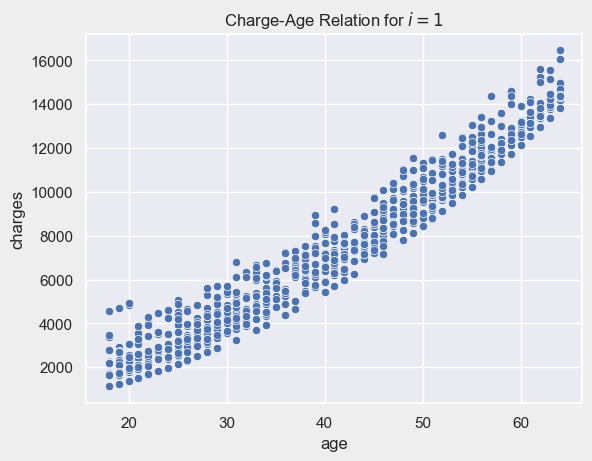

In [13]:
sns.scatterplot(data=df_low, x=Col.age, y=Col.charges)
plt.title('Charge-Age Relation for $i = 1$')
plt.show()

Now, we see that our assumption of a linear correlation here was wrong!  There is some arching
going on.  We can scale the axes to try and see if we can narrow down the nature of the
function we are looking for:

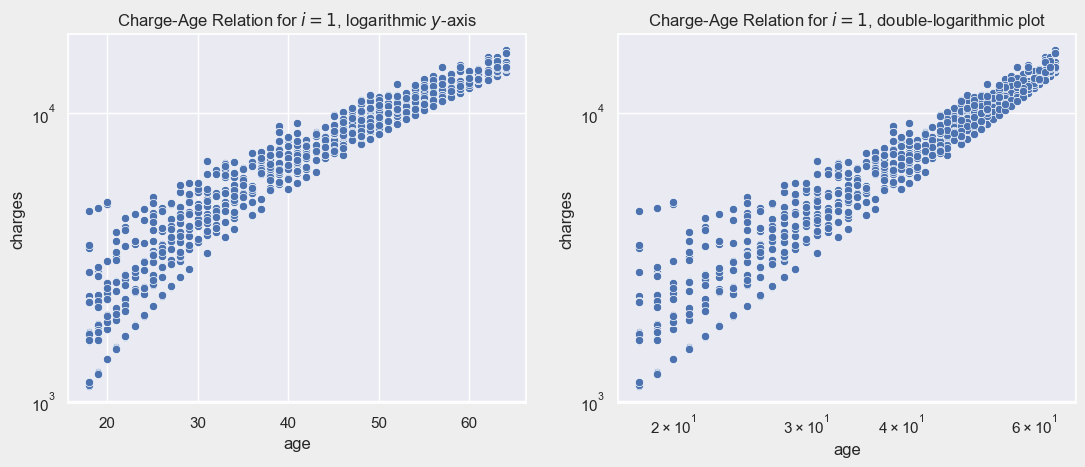

In [14]:
plt.figure(figsize=(13, 4.8))
plt.subplot(121)
sns.scatterplot(data=df_low, x=Col.age, y=Col.charges)
plt.yscale('log')
plt.title('Charge-Age Relation for $i=1$, logarithmic $y$-axis')
plt.subplot(122)
sns.scatterplot(data=df_low, x=Col.age, y=Col.charges)
plt.xscale('log')
plt.yscale('log')
plt.title('Charge-Age Relation for $i=1$, double-logarithmic plot')
plt.show()

The somewhat linear behavior in the double-logarithmic plot hints towards a polynomial
correlation.  And checking this quickly by assuming it to be 2nd degree and plotting
the charges over $a^2$ appears to confirm that:

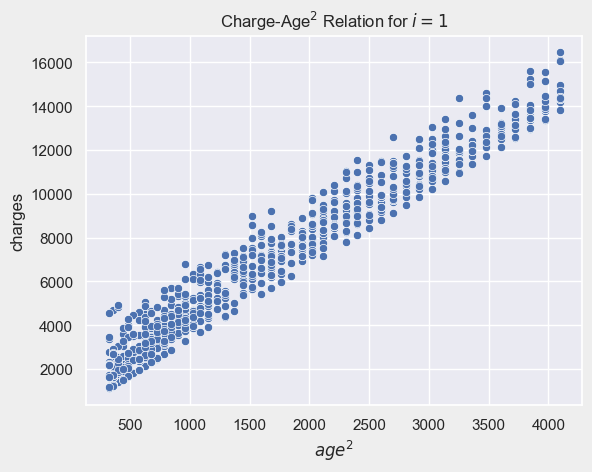

In [15]:
df_low[Col.age2] = df_low.age**2    # Col.age2 = '$age^2$'

df_low.to_csv('data/df_low.csv', index=False)   # update .csv file; will be used soon

sns.scatterplot(data=df_low, x=Col.age2, y=Col.charges)
plt.title('Charge-Age$^2$ Relation for $i=1$')
plt.show()

Thus, we can perform a linear regression on this data to find
a (still somewhat naive) prediction of insurance charges per age.

We will do so by using and comparing three (slightly) different Python packages.
In order to avoid the notebook getting too big, we will split the three approaches
off here and return once we exercised them individually.

| Notebook                                                              | Package          |
| --------------------------------------------------------------------- | ---------------- |
| [SciKit-Learn approach](./06-linear-regression-using-scikit-learn.ipynb)          | `sklearn`        |
| [Statsmodel.API approach](./07-linear-regression-using-statsmodels-api.ipynb) | `statsmodel.api` |
| [ScyPy.Stats approach](./08-linear-regression-using-scipy-stats.ipynb)       | `scipy.stats`    |

In summary, all packages deliver essentially the same result, but they might need
some individual setup and/ or provide more or less insight into the statistics of
the result.  In terms of predictions, the `statsmodel.api` package has the most
convenient access to confidence niveous, as they can immediately called from
the regression result via the `.conf_int()` or the `conf_int_el()` methods.

As a quick recap, the three packages found the following parameters for our regression
attempt:

In [16]:
model = quick_regression(df_low[Col.age2], df_low[Col.charges])
print(f'Intercept:\t{model.intercept}')
print(f'Slope:\t\t{model.slope}')

Intercept:	1160.1072156361256
Slope:		3.3639813030572436


The confidence niveous differ a bit between `statsmodel.api` and their actual computation in
the `scipy.stats` notebook, but only by a negligible amount compared to the `costs` scale of
our data.  Thus, we will stick with the ones provided by `statsmodel.api`:

In [17]:
print(f'Intercept\tlower limit:\t{model.intercept_lower}')
print(f'Intercept\tupper limit:\t{model.intercept_upper}')
print(f'Slope\t\tlower limit:\t{model.slope_lower}')
print(f'Slope\t\tupper limit:\t{model.slope_upper}')

Intercept	lower limit:	1071.4021420650429
Intercept	upper limit:	1253.0234719199973
Slope		lower limit:	3.3208334601111686
Slope		upper limit:	3.4076569037110462


However, `sklearn` allows us to try something else with nigh-to-none extra effort
(which has not been showcased in the respective notebook):  One can perform polynomial
regression within the linear module by setting up the arguments a little bit differently,
and use its capabilities to process regressions of linear functions over multiple
independent arguments.  We will use this now to attempt to fit a quadratic formula
over the unscaled dataset, and compare it to the ones we have derived so far.

In [18]:
# Provide arguments in a slightly different way
x = pd.DataFrame(df_low.age)
x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)  # new x values
y = pd.DataFrame(df_low.charges)
model = LinearRegression().fit(x_, y)                                   # same base model
print(f'R^2:\t\t{model.score(x_, y)}\nIntercept:\t{model.intercept_[0]}\nCoefficients:\t{model.coef_[0]}')

R^2:		0.9618577716253013
Intercept:	-818.7194546260425
Coefficients:	[110.97949705   1.99568751]


Judging just by $R^2$, this approach *seems* to fit the data better.  However, plotting this
result (over the one we already arrived at) shows that the quadratic regression does *not*
capture the behavior of the data as good as our linear one!

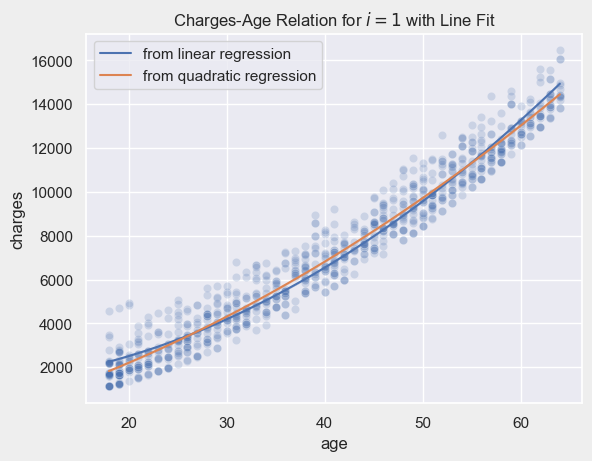

In [19]:
#df_low['line_pol'] = df_low.age.map(lambda age: model.intercept_[0] + age * model.coef_[0, 0] + age**2 * model.coef_[0, 1])
df_low['line_pol'] = model.predict(x_)

# Quickly reconstruct the regression from the previous attempt:
model = quick_regression(df_low[Col.age2], df_low[Col.charges])
df_low[Col.line] = model.predict(df_low[Col.age2])

# Plot the results
sns.scatterplot(data=df_low, x=Col.age, y=Col.charges, alpha=.2)
sns.lineplot(data=df_low, x=Col.age, y=Col.line, label='from linear regression')
sns.lineplot(data=df_low, x=Col.age, y='line_pol', label='from quadratic regression')
plt.title('Charges-Age Relation for $i=1$ with Line Fit')
plt.show()

Thus, moving forward, we will stick with the former result.

# Summary

So far, we obtained a fit for the lowest charge levels.  And assuming
the higher ones share the same curvature, from here on onwards the task
of fitting them as well becomes the search for the individual offsets/
intercepts.  The last thing we need to do here before we can move on
is to store the new version of `df_low` in its own `.csv` file.
In the [next notebook](./09-offsets-and-more-insights.ipynb) we will
attempt that and discover some more underlying structures as we go.

In [20]:
df_low.to_csv('data/df_low_fitted.csv', index=False)

--------------------

Back to the [README](./README.md)

To the [next notebook](./09-offsets-and-more-insights.ipynb)